In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Necessary Libraries

In [1]:
!pip install matplotlib
import matplotlib.pyplot as plt 
import math

'pip' is not recognized as an internal or external command,
operable program or batch file.


## Setup

In [2]:
plt.style.use('seaborn')

# Plotting Functions

In [3]:
def plot_V(axis , v , x ,  spike_times):
    axis.set_xlabel('iteration')
    axis.set_ylabel('V')
    axis.axhline(min(v) , color="green" , linestyle="--" , label="min voltage")
    axis.axhline(max(v) , color="orange" , linestyle="--" , label="max voltage") 
    for sp_time in spike_times:
        axis.axvline(sp_time , color="red" , linestyle="--")
    axis.legend()
    axis.plot(x , v)
    
def plot_input_current(axis , I , x):
    axis.set_xlabel('iteration')
    axis.set_ylabel('I')
    axis.plot(x , I)
    
def plot_neuron_Info(v , I , fig_size=(10,10) , spt=[]):
    x = list(range(len(v)))
    fig , axis = plt.subplots( 2 , figsize = fig_size)
    plot_V(axis[0] , v , x , spt)
    plot_input_current(axis[1],I , x)
    plt.show()

## Leaky Integrate & Fire Model
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t)$, $\Delta u = u - u_{rest}$ ,$I_t = I(t)$

#### Threshhold
$ u(t) = \theta \implies \text{Fire + Rest } (u = u_{rest}) $

In [4]:
class LIF:

    def __init__(self , parameters):
        self.tau = parameters['tau']
        self.R = parameters['R']
        self.v_reset = parameters['v_reset']
        self.v_rest = parameters['v_rest']
        self.threshold = parameters['threshold']
        self.dt = parameters['dt']
        self.v = self.v_rest

        
    def getdv(self , I):
        return (-(self.v - self.v_rest) + self.R * I) \
                *self.dt / self.tau
    
        
    def new_iteration(self, I , iteration):
        spike = 0
        self.v += self.getdv(I)
        if self.v >= self.threshold:
            self.v = self.v_reset
            spike = 1
        return spike
            
            
    
    def simulate(self , I_t , T):
        self.voltage = []
        self.spike_times = []
        for iteration in range(T):
            spike_flag = self.new_iteration(I_t[iteration] , iteration)
            if spike_flag:
                spike_times.append(iteration)
            voltage.append(self.v)
        
        return self.voltage , self.spike_times
            



# Simulate LIF Model

In [5]:
def get_step_input_currents(I_values , I_period):
    I = []
    for value , time in zip(I_values , I_period):
        temp = [value for _ in range(time)]
        I += temp
    return I

## Set input and model parameters

In [6]:
I_values = [0 , 10 , 0]
I_periods = [5 , 30 , 10]
inputI = get_step_input_currents(I_values , I_periods)
config = {
    "v_reset" : -70,
    "v_rest": -70,
    "tau" : 10 ,
    "R" : 2 ,
    "threshold" : -50,
    "dt" : 1
}

In [7]:
neuron = LIF(config)
v , s = neuron.simulate(inputI , sum(I_periods))

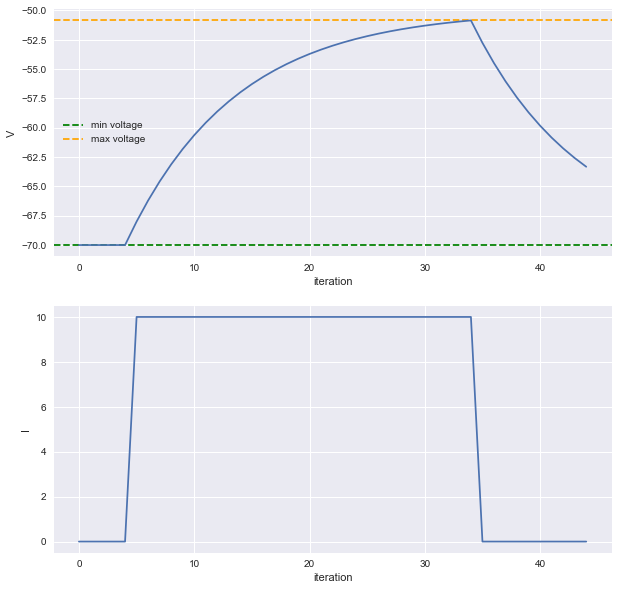

In [8]:
plot_neuron_Info(v , inputI , spt=s)

## Exponential LIF Model
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t) + \Delta_{T}exp(\frac{u - \theta_{rh}}{\Delta_{T}})$

First part describe the leak of a passive membrane same as LIF model.

$\Delta_{T}$ is the sharpness parameter.

$\theta_{rh}$ is the firing threshold.

In [9]:
class ELIF:

    def __init__(self , parameters):
        self.tau = parameters['tau']
        self.R = parameters['R']
        self.v_reset = parameters['v_reset']
        self.v_rest = parameters['v_rest']
        self.threshold = parameters['threshold']
        self.dt = parameters['dt']
        self.deltaT = parameters['deltaT']
        self.v = self.v_rest

        

    def getdv(self , I):
        return ((-(self.v - self.v_rest) + self.R * I) + self.deltaT * math.exp((self.v - self.threshold)/self.deltaT)) * \
        (self.dt / self.tau)
    
    
        
    def new_iteration(self, I , iteration):
        spike = 0
        self.v += self.getdv(I)
        if self.v >= self.threshold:
            self.v = self.v_reset
            spike = 1
        return spike
            
            
    
    def simulate(self , I_t , T):
        self.voltage = []
        self.spike_times = []
        for iteration in range(T):
            spike_flag = self.new_iteration(I_t[iteration] , iteration)
            if spike_flag:
                spike_times.append(iteration)
            voltage.append(self.v)
        
        return self.voltage , self.spike_times
            


## Addaptive Exponential LIF Model
#### formulate
$\tau.\frac{du}{dt} = -(u - u_{rest}) + R.I(t) + \Delta_{T}exp(\frac{u - \theta_{rh}}{\Delta_{T}}) - Rw$

$\tau.\frac{dw}{dt} = a(u - u_{rest}) - w + b \tau_w \sum\limits_{t^f}\sigma(t - t^f)$

- At each threshold crossing, the adaptation variable w is increased by an amount b
- Adaptation is characterized by two parameters:
    - the parameter a is the source of subthreshold adaptation, because it couples adaptation to the voltage
    - spike-triggered adaptation is controlled by a combination of a and b.

In [ ]:
class AELIF:
    
    def __init__(self , parameters):
        self.tau = parameters['tau']
        self.R = parameters['R']
        self.v_reset = parameters['v_reset']
        self.v_rest = parameters['v_rest']
        self.threshold = parameters['threshold']
        self.dt = parameters['dt']
        self.deltaT = parameters['deltaT']
        self.tau_m = parameters['tau_m']
        self.tau_w = parameters['tau_w']
        self.a = parameters['a']
        self.b = parameters['b']
        self.w = parameters['w']
        self.v = self.v_rest

    
    def getdv(self , I):
        return ((-(self.v - self.v_rest) + self.R * (I - self.w)) \
        + self.deltaT * math.exp((self.v - self.threshold)/self.deltaT)) * self.dt / self.tau_m
    
    
    def getdw(self , t):
        return self.a * (self.v - self.v_rest) - self.w + self.b * self.tau_w * self.spike_times.count(t)
    
    
    def new_iteration(self, I , iteration):
        spike = 0
        self.v += self.getdv(I)
        self.w += self.getdw(iteration)
        if self.v >= self.threshold:
            self.v = self.v_reset
            spike = 1
        return spike
            
            
    
    def simulate(self , I_t , T):
        self.voltage = []
        self.spike_times = []
        for iteration in range(T):
            spike_flag = self.new_iteration(I_t[iteration] , iteration)
            if spike_flag:
                spike_times.append(iteration)
            voltage.append(self.v)
        
        return self.voltage , self.spike_times
    

In [ ]:
def createAndRunModel(model_name , config , duration , plot = False):
    if model_name == "LIF":
        behaviourObj = LIF(config)
    elif model_name == "ELIF":
        behaviourObj = ELIF(config)
    elif model_name == "AELIF":
        behaviourObj = AELIF(config)
    else:
        print("Invalid model name")
        return
    v , s = behaviourObj.simulate(config['I_t'] , duration)
    if plot:
        plot_neuron_info(v , config['I_t'] , spt=s)
    return v, s

<div dir="rtl">
    برای اینکه 
    firing rate
    را محاسبه کنیم حداقل به دو
    spike
    نیاز داریم.
</div>

In [ ]:
def getFICurveData(model_name , config , minI , maxI , duration):
    I_values = []
    f = []
    for current_I in range(minI , maxI+1):
        I_values.append(current_I)
        inputI = generateStepI([current_I] , [duration])
        config['I_t'] = inputI
        current_net = createAndRunModel(model_name , config , duration)
        T_values = current_net['n.T' , 0]
        current_T = [t for t in T_values if t != -1]
        if not current_T:
            f.append(0)
        else:    
            f.append(1/current_T[0])
    return I_values , f


def plotFICurve(model_name , config , minI , maxI , duration):
    I , f = getFICurveData(model_name , config , minI , maxI , duration)
    plt.plot(I , f)
    plt.xlabel('I')
    plt.ylabel('f')
    plt.title('frequency-current relation')
    plt.show()
        

In [ ]:
plotFICurve("LIF" , config , 1 , 40 , 200)

<div dir="rtl">
    حال به همین ترتیب مدل 
    ELIF
    را میسازیم
</div>

<div dir="rtl">
    پارامتر های مدل به شرح زیر هستند
    
</div>

*     $v_{reset}$
*     $v_{rest}$
*     $\tau$
*     $R$
*     $I_t$
*     $threshold$
*     $dt$  
*     $\Delta_T$ 

In [ ]:
class ELIF_Behaviour(Behaviour):
    
    def set_variables(self, neurons):
        self.set_init_attrs_as_variables(neurons)
        neurons.v = neurons.v_rest
        neurons.spike_times = []
        neurons.T = -1

    
    @staticmethod
    def getdv(neuron , I):
        return ((-(neuron.v - neuron.v_rest) + neuron.R * I) + neuron.deltaT * math.exp((neuron.v - neuron.threshold)/neuron.deltaT)) * (neuron.dt / neuron.tau)
    
    
    @staticmethod
    def setT(neurons):
        if len(neurons.spike_times) >= 2:
            neurons.T = neurons.spike_times[-1] - neurons.spike_times[-2]
    
        
    def new_iteration(self, neurons):
        neurons.v += ELIF_Behaviour.getdv(neurons , neurons.I_t[neurons.iteration-1])
        if neurons.v >= neurons.threshold:
            neurons.v = neurons.v_reset
            neurons.spike_times.append(neurons.iteration-2)
            ELIF_Behaviour.setT(neurons)

<div dir="rtl">
    همچنین برای 
    AELIF
    پارامتر های زیر را تعریف میکنیم
</div>

*     $v_{reset}$
*     $v_{rest}$
*     $\tau_{m}$
*     $\tau_w$
*     $a$
*     $b$
*     $w$
*     $R$
*     $I_t$
*     $threshold$
*     $dt$  
*     $\Delta_T$ 


In [ ]:
class AELIF_Behaviour(Behaviour):
    
    def set_variables(self, neurons):
        self.set_init_attrs_as_variables(neurons)
        neurons.v = neurons.v_rest
        neurons.spike_times = []
        neurons.T = -1

    
    @staticmethod
    def getdv(neuron , I):
        return ((-(neuron.v - neuron.v_rest) + neuron.R * (I - neuron.w)) \
        + neuron.deltaT * math.exp((neuron.v - neuron.threshold)/neuron.deltaT)) * neuron.dt / neuron.tau_m
    
    @staticmethod
    def getdw(neuron , t):
        return neuron.a * (neuron.v - neuron.v_rest) - neuron.w + neuron.b * neuron.tau_w * neuron.spike_times.count(t)
    
    
    @staticmethod
    def setT(neurons):
        if len(neurons.spike_times) >= 2:
            neurons.T = neurons.spike_times[-1] - neurons.spike_times[-2]
    
        
    def new_iteration(self, neurons):
        neurons.v += AELIF_Behaviour.getdv(neurons , neurons.I_t[neurons.iteration-1])
        neurons.w += AELIF_Behaviour.getdw(neurons , neurons.iteration-1)
        if neurons.v >= neurons.threshold:
            neurons.v = neurons.v_reset
            neurons.spike_times.append(neurons.iteration-1)
            AELIF_Behaviour.setT(neurons)

In [ ]:
def generateNormalI(mean , std , size):
    return np.random.normal(mean , std , size)

In [ ]:
params = {
        "v_reset" : -65,
        "v_rest": -70,
        "tau" : 10 ,
        "R" : 5 ,
        "I_t": generateNormalI(8 , 0 , 100),
        "threshold" : -40,
        "dt" : 1
    }
createAndRunModel("LIF" , params , 100 , plot=True)

In [ ]:
def analyseStdOfI(model_name , params  ,stds , mean , duration):
    for std in stds:
        params["I_t"] = generateNormalI(mean , std , duration)   
        createAndRunModel(model_name , params ,duration , plot=True)

In [ ]:
def cv_ISI(net):
    spikes = net['n.spike_times' , 0][-1]
    if len(spikes) <=2 :
        return
    start_spike_times = np.array(spikes[:-1])
    end_spike_times = np.array(spikes[1:])
    ISI = end_spike_times - start_spike_times
    cv = np.std(ISI) / np.mean(ISI)
    plt.hist(ISI)
    plt.xlabel("ISI")
    plt.ylabel("count")
    plt.title("histogram of ISI")
    print(cv)

#params["I_t"] = generateNormalI(8 , 1 , 150)
#n = createAndRunModel("LIF" , params , 150)
#cv_ISI(n)

In [ ]:
params["I_t"] = generateNormalI(8 , 5 , 150)
n = createAndRunModel("LIF" , params , 150)
cv_ISI(n)

In [ ]:
params = {
    "v_reset" : -70,
    "v_rest": -70,
    "tau_m" : 5 ,
    "tau_w": 15,
    "R" : 10 ,
    "threshold" : -48,
    "dt" : 0.01 ,
    "deltaT": 1 ,
    "a": 1,
    "b": 0.5,
    "w": 2 
}
I_mean = np.arange(2,50,3)
I_std = np.arange(0,30,1.5)
spk_count = np.zeros((len(I_mean),len(I_std)))
cv_isi = np.empty((len(I_mean),len(I_std)))
cv_isi[:] = np.NaN
duration = 400

for i in range(len(I_mean)):
    for j in range(len(I_std)):
        I_normal = generateNormalI(I_mean[i] , I_std[j] ,duration) 
        params["I_t"] = I_normal
        net = createAndRunModel("AELIF" , params , duration)
        spike_times = net['n.spike_times' , 0]
        if not spike_times:
            continue
        spk_count[i,j] = len(spike_times[-1])
        if spk_count[i,j]>3:
            isi = np.diff(np.array(spike_times[-1]))
            cv_isi[i,j] = np.std(isi)/np.mean(isi)

In [ ]:
plt.figure(figsize=(30,10))
plt.subplot(2,2,2)
plt.plot(spk_count,cv_isi,'.')
plt.xlabel('Spike count')
plt.ylabel('Spike time irregularity (CV-ISI)');
plt.legend()

In [ ]:
def iterativeFICurve(model_name , params , param_name,values , minI , maxI , duration):
    for value in values:
        params[param_name] = value
        plotFICurve(model_name , params , minI , maxI , duration)

In [ ]:
inputI = generateStepI([25] , [400])
params = {
    "v_reset" : -70,
    "v_rest": -70,
    "tau_m" : 5 ,
    "tau_w": 15,
    "R" : 10 ,
    "threshold" : -48,
    "dt" : 0.01 ,
    "deltaT": 1 ,
    "a": 1,
    "b": 0.5,
    "w": 2 ,
    "I_t": inputI
}
createAndRunModel("AELIF" , params , 400)

In [ ]:
tau_values = [5 , 9 , 15 , 21 , 27]
inputI = generateStepI([25] , [400])
params = {
    "v_reset" : -70,
    "v_rest": -70,
    "tau_m" : 5 ,
    "tau_w": 15,
    "R" : 10 ,
    "threshold" : -48,
    "dt" : 0.01 ,
    "deltaT": 1 ,
    "a": 1,
    "b": 0.5,
    "w": 2 ,
    "I_t": inputI
}
#iterativeFICurve("AELIF" , params , "tau_w" , tau_values , 10 , 50 , 100)


In [ ]:
inputI = generateNormalI(25 , 9 , 400)
params["I_t"] = inputI
m = createAndRunModel("AELIF" , params , 400)

In [ ]:
m["n.spike_times" , 0]

In [ ]:
stds = [1 , 4 , 9 , 15 , 20 , 25 , 31 , 36]
#analyseStdOfI("AELIF" , params  ,stds , 25 , 400)
for std in stds:
    inputI = generateNormalI(45 , std , 500)
    params["I_t"] = inputI
    n = createAndRunModel("AELIF" , params , 500)
    cv_ISI(n)
    plt.show()

In [ ]:
inputI = generateStepI([0 , 8 , 0] , [10 , 60 , 18])
params = {
    "v_reset" : -65,
    "v_rest": -65,
    "tau" : 8 ,
    "R" : 5 ,
    "I_t": inputI ,
    "threshold" : -10,
    "dt" : 1 ,
    "deltaT": 2
}
createAndRunModel("ELIF" , params , 88 , plot=True)